# Plots for the grid search results
Based on the results from the notebooks:
- `IHCM_parameter_grid_search.ipynb`
- `IHCM_vs_Oracle_grid_search.ipynb`

**TODO:** Fix change on plotting behavior: doing parameter grid plots first changes the model comparison plots. I think it's related to using seaborn at some point that it's changing the global plotting arguments.

In [1]:
import json
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import poisson

import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
# Some plotting parameters
import matplotlib as mpl
# Customize font sizes for different elements
title_font_size = 16
label_font_size = 14
tick_font_size = 12
legend_font_size = 11

# Set font sizes for title, labels, and ticks
mpl.rcParams['axes.titlesize'] = title_font_size
mpl.rcParams['axes.labelsize'] = label_font_size
mpl.rcParams['xtick.labelsize'] = tick_font_size
mpl.rcParams['ytick.labelsize'] = tick_font_size
mpl.rcParams['legend.fontsize'] = legend_font_size

# Some nice plotting colors
cs = [
    "#4169E1",  # Royal Blue
    "#DC143C",  # Crimson
    "#228B22",  # Forest Green
    "#FF8C00",  # Dark Orange
    "#800080",  # Purple
    "#008080",  # Teal
    "#808000",  # Olive
    "#708090",  # Slate Gray
    "#FF1493",  # Deep Pink
    "#8B0000"   # Dark Red
]

In [3]:
# DATA PROCESSING HELPERS
def convert_keys_to_numbers(data):
    """Converts keys to numbers if they are numbers; if not, leave them as  strings."""
    
    if isinstance(data, dict):
        formatted_data = {}
        for key, value in data.items():
            if '.' in key:
                try:
                    formatted_key = float(key)
                except:
                    formatted_key = key
            else:
                try:
                    formatted_key = int(key)
                except:
                    formatted_key = key
            formatted_data[formatted_key] = convert_keys_to_numbers(value)
        return formatted_data
        
    elif isinstance(data, list):
        return [convert_keys_to_numbers(item) for item in data]
    else:
        return data

In [4]:
# OTHER HELPERS

# Parameter grid helpers
def compute_percolation_regime(p_app, k_avg, p_hir=1):
    return 1/( p_app * k_avg * p_hir )
def compute_hiring_regime(p_app, k_avg):
    return 1/( (1 -p_app) * k_avg)

def surplus_chain(chain_size, payload_frac=0.5):
    if payload_frac == 0.5:
        return 2**(-chain_size)
    else:
        return 1 - (payload_frac/(1 - payload_frac)*(1 - payload_frac**chain_size))

def surplus_total( chain_sizes, payload_frac=0.5 ):
    surpluses = [surplus_chain(chain_size) for chain_size in chain_sizes]
    return np.mean( surpluses )

def dict_to_matrix( D, func=np.mean ):
    i1 = list( D.keys() )[0]
    return np.array( [ [ func(D[i][j]) for j in D[i1].keys()] for i in D.keys()]  )

# Reading data

In [5]:
%%time
# Parameters
λ = 3
k_avg1 = 20
k_avg2 = 50
n_sims1 = 1000
n_sims2 = 2500
n_sims3 = 100
n_nodes = 5000
p_hir1 = 1.0
p_hir2 = 0.5
p_hir3 = 0.1
p_r = 0.1
ρ_o = 0.5

# Filenames
suffix_s = '_lambda={}_kavg={}_n_sims={}_ER_n_nodes={}'.format( λ, k_avg1, n_sims1, n_nodes )
suffix_o = '_lambda={}_rho={}_n_sims={}_ER_n_nodes={}'.format( λ, ρ_o , n_sims1, n_nodes )
suffix_r = '_lambda={}_pr={}_n_sims={}_ER_n_nodes=5000'.format( λ, p_r, n_sims2, n_nodes )
suffix_p1 = '_p_h={}_n_sims={}_ER_n_nodes={}_kavg={}'.format( p_hir1, n_sims3, n_nodes, k_avg2 )
suffix_p2 = '_p_h={}_n_sims={}_ER_n_nodes={}_kavg={}'.format( p_hir2, n_sims3, n_nodes, k_avg2 )
suffix_p3 = '_p_h={}_n_sims={}_ER_n_nodes={}_kavg={}'.format( p_hir3, n_sims3, n_nodes, k_avg2 )

filenames = [    
    '../outputs/social_chain_depths'+suffix_s,
    '../outputs/oracle_chain_depths'+suffix_o,
    '../outputs/social_chain_depths'+suffix_r,
    '../outputs/oracle_chain_depths'+suffix_r,
    '../outputs/social_is_hired'+suffix_s,
    '../outputs/oracle_is_hired'+suffix_o,
    '../outputs/social_is_hired'+suffix_r,
    '../outputs/oracle_is_hired'+suffix_r,
    '../outputs/social_num_applicants'+suffix_s,
    '../outputs/oracle_num_applicants'+suffix_o,
    '../outputs/social_num_applicants'+suffix_r,
    '../outputs/oracle_num_applicants'+suffix_r,
    '../outputs/ihcm_chain_depths'+suffix_p1,
    '../outputs/ihcm_chain_depths'+suffix_p2,
    '../outputs/ihcm_chain_depths'+suffix_p3,
    '../outputs/ihcm_chain_is_hired'+suffix_p1,
    '../outputs/ihcm_chain_is_hired'+suffix_p2,
    '../outputs/ihcm_chain_is_hired'+suffix_p3,
    '../outputs/ihcm_chain_applicants_reach'+suffix_p1,        
    '../outputs/ihcm_chain_applicants_reach'+suffix_p2,    
    '../outputs/ihcm_chain_applicants_reach'+suffix_p3,
]

# Reading
data_vec = []
for filename in filenames:
    with open(filename+'.json', 'r') as f:
        data = json.load(f)
        data = convert_keys_to_numbers(data)
        data_vec.append( data )

# Naming
results_social_depths_varying_pr = data_vec[0]
results_oracle_depths_varying_pr = data_vec[1]
results_social_depths_varying_k = data_vec[2]
results_oracle_depths_varying_rho = data_vec[3]
results_social_hiring_varying_pr = data_vec[4]
results_oracle_hiring_varying_pr = data_vec[5]
results_social_hiring_varying_k = data_vec[6]
results_oracle_hiring_varying_rho = data_vec[7]
results_social_applicants_varying_pr = data_vec[8]
results_oracle_applicants_varying_pr = data_vec[9]
results_social_applicants_varying_k = data_vec[10]
results_oracle_applicants_varying_rho = data_vec[11]
results_ihcm_depths_params_ph1 = data_vec[12]
results_ihcm_depths_params_ph2 = data_vec[13]
results_ihcm_depths_params_ph3 = data_vec[14]
results_ihcm_hiring_params_ph1 = data_vec[15]
results_ihcm_hiring_params_ph2 = data_vec[16]
results_ihcm_hiring_params_ph3 = data_vec[17]
results_ihcm_applicants_params_ph1 = data_vec[18]
results_ihcm_applicants_params_ph2 = data_vec[19]
results_ihcm_applicants_params_ph3 = data_vec[20]

print(len(data_vec))
del data_vec

21
CPU times: user 694 ms, sys: 19.6 ms, total: 714 ms
Wall time: 723 ms


In [6]:
## PARAMETER ARRAY INFERENCE FROM RESULTS DICTIONARIES

## Grid-based
# grid of application and activation probabilities
p_acts = [float(s[6:]) for s in results_ihcm_applicants_params_ph1.keys()]
p_apps = [float(s[6:]) for s in results_ihcm_applicants_params_ph1[f'p_act={p_acts[0]}'].keys()]

## Model-comparison-based
# Confidence intervals for vacancy specificities
CIs = list(results_social_depths_varying_k.keys())
# average number of connections per node array
k_avgs = [ float(ci) for ci in results_social_depths_varying_k[CIs[0]].keys()]
# Oracle reach array
ρ_os = [ float(ci) for ci in results_oracle_depths_varying_rho[CIs[0]].keys()]
# activation/recommendation probability array
p_rs = [ float(ci) for ci in results_social_depths_varying_pr[CIs[0]].keys()]

# Plotting

## Parameter grid behavior

### $p_h = 1$

In [7]:
percolation_regime = np.clip(0, 1, compute_percolation_regime( np.array(p_apps), k_avg2, p_hir=p_hir1 ))
hiring_regime = np.clip(0, 1, compute_hiring_regime( np.array(p_apps), k_avg2, ))

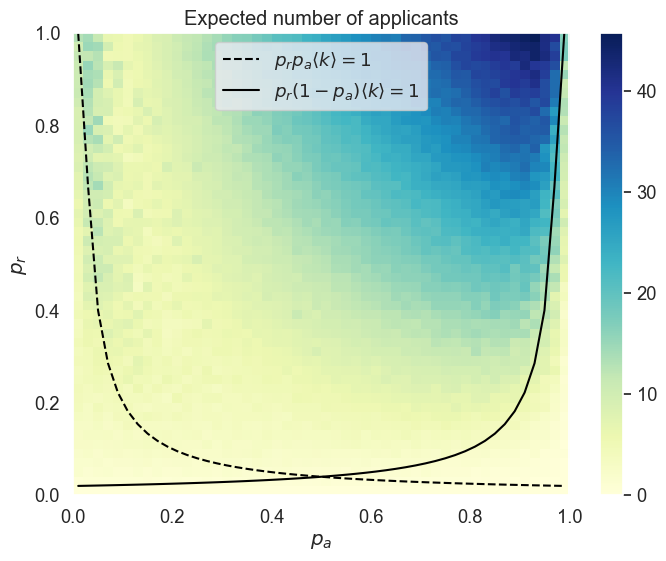

In [8]:
### Transform results to matrix data for plotting
heatmap_data = dict_to_matrix(results_ihcm_applicants_params_ph1, func=np.mean)

# Set figure dimensions
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Plot data
plt.imshow(heatmap_data, cmap="YlGnBu", extent=[0,1,0,1], label='', aspect='auto', origin='lower')
plt.colorbar()
plt.plot(p_apps, percolation_regime, color='black', ls='--', label='$p_r p_a \langle k \\rangle = 1$' )
plt.plot(p_apps, hiring_regime, color='black', ls='-', label='$p_r (1 - p_a) \langle k \\rangle = 1$' )

plt.title("Expected number of applicants")
plt.xlabel("$p_a$")
plt.ylabel("$p_r$")
plt.plot(color='black', marker ='o')
plt.grid(False)
plt.legend();

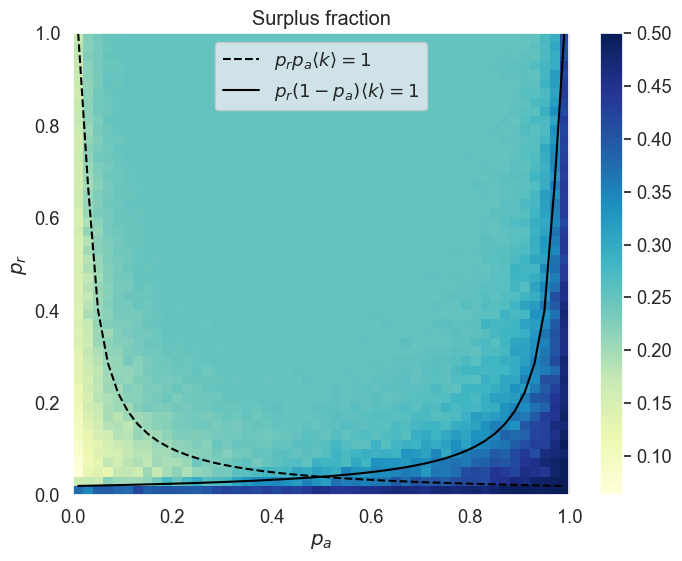

In [9]:
### Transform results to matrix data for plotting
heatmap_data =dict_to_matrix(results_ihcm_depths_params_ph1, func=surplus_total)

# Set figure dimensions
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Plot data
plt.imshow(heatmap_data, cmap="YlGnBu", extent=[0,1,0,1], label='', aspect='auto', origin='lower')
plt.colorbar()
plt.plot(p_apps, percolation_regime, color='black', ls='--', label='$p_r p_a \langle k \\rangle = 1$' )
plt.plot(p_apps, hiring_regime, color='black', ls='-', label='$p_r (1 - p_a) \langle k \\rangle = 1$' )

plt.title("Surplus fraction")
plt.xlabel("$p_a$")
plt.ylabel("$p_r$")
plt.plot(color='black', marker ='o')
plt.grid(False)
plt.legend();

### $p_h = 0.5$

In [10]:
percolation_regime = np.clip(0, 1, compute_percolation_regime( np.array(p_apps), k_avg2, p_hir=p_hir2 ))
hiring_regime = np.clip(0, 1, compute_hiring_regime( np.array(p_apps), k_avg2, ))

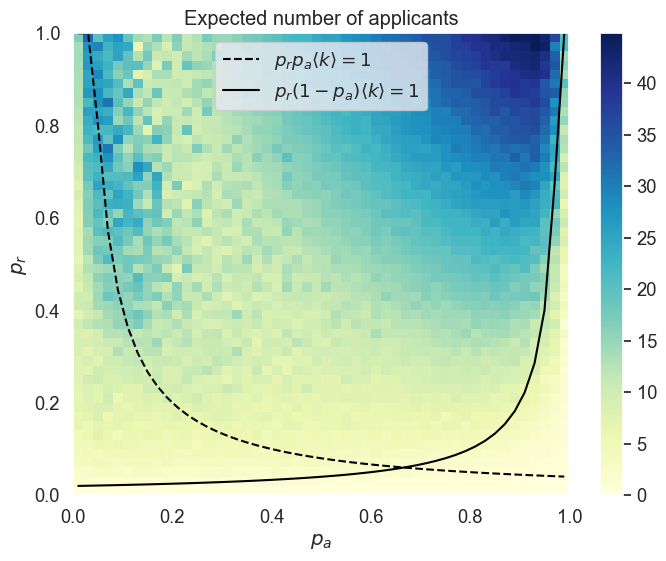

In [11]:
### Transform results to matrix data for plotting
heatmap_data =dict_to_matrix(results_ihcm_applicants_params_ph2, func=np.mean)

# Set figure dimensions
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Plot data
plt.imshow(heatmap_data, cmap="YlGnBu", extent=[0,1,0,1], label='', aspect='auto', origin='lower')
plt.colorbar()
plt.plot(p_apps, percolation_regime, color='black', ls='--', label='$p_r p_a \langle k \\rangle = 1$' )
plt.plot(p_apps, hiring_regime, color='black', ls='-', label='$p_r (1 - p_a) \langle k \\rangle = 1$' )

plt.title("Expected number of applicants")
plt.xlabel("$p_a$")
plt.ylabel("$p_r$")
plt.plot(color='black', marker ='o')
plt.grid(False)
plt.legend();

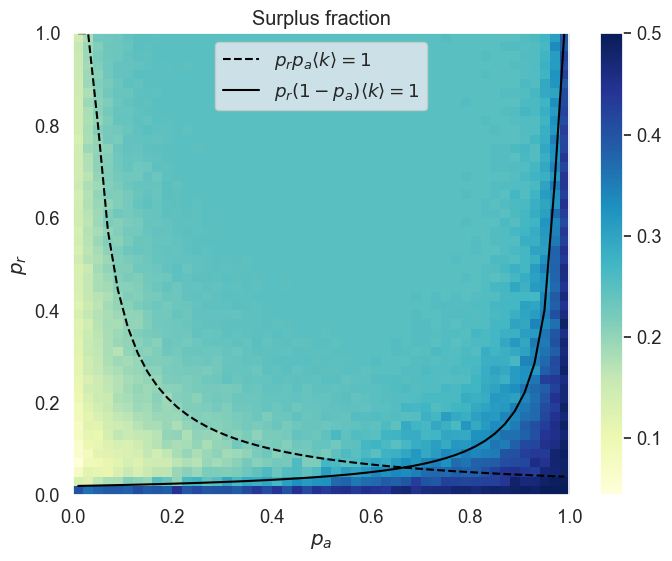

In [12]:
### Transform results to matrix data for plotting
heatmap_data =dict_to_matrix(results_ihcm_depths_params_ph2, func=surplus_total)

# Set figure dimensions
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Plot data
plt.imshow(heatmap_data, cmap="YlGnBu", extent=[0,1,0,1], label='', aspect='auto', origin='lower')
plt.colorbar()
plt.plot(p_apps, percolation_regime, color='black', ls='--', label='$p_r p_a \langle k \\rangle = 1$' )
plt.plot(p_apps, hiring_regime, color='black', ls='-', label='$p_r (1 - p_a) \langle k \\rangle = 1$' )

plt.title("Surplus fraction")
plt.xlabel("$p_a$")
plt.ylabel("$p_r$")
plt.plot(color='black', marker ='o')
plt.grid(False)
plt.legend();

### $p_h = 0.1$

In [13]:
percolation_regime = np.clip(0, 1, compute_percolation_regime( np.array(p_apps), k_avg2, p_hir=p_hir3 ))
hiring_regime = np.clip(0, 1, compute_hiring_regime( np.array(p_apps), k_avg2, ))

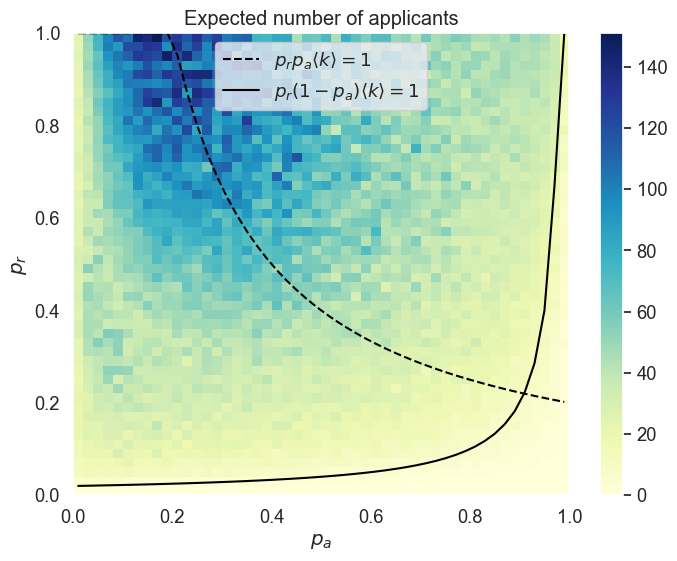

In [14]:
### Transform results to matrix data for plotting
heatmap_data =dict_to_matrix(results_ihcm_applicants_params_ph3, func=np.mean)

# Set figure dimensions
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Plot data
plt.imshow(heatmap_data, cmap="YlGnBu", extent=[0,1,0,1], label='', aspect='auto', origin='lower')
plt.colorbar()
plt.plot(p_apps, percolation_regime, color='black', ls='--', label='$p_r p_a \langle k \\rangle = 1$' )
plt.plot(p_apps, hiring_regime, color='black', ls='-', label='$p_r (1 - p_a) \langle k \\rangle = 1$' )

plt.title("Expected number of applicants")
plt.xlabel("$p_a$")
plt.ylabel("$p_r$")
plt.plot(color='black', marker ='o')
plt.grid(False)
plt.legend();

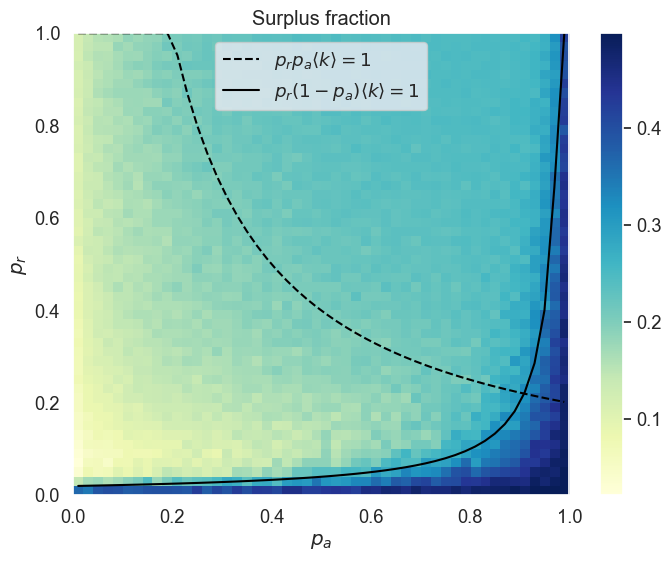

In [15]:
### Transform results to matrix data for plotting
heatmap_data =dict_to_matrix(results_ihcm_depths_params_ph3, func=surplus_total)

# Set figure dimensions
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Plot data
plt.imshow(heatmap_data, cmap="YlGnBu", extent=[0,1,0,1], label='', aspect='auto', origin='lower')
plt.colorbar()
plt.plot(p_apps, percolation_regime, color='black', ls='--', label='$p_r p_a \langle k \\rangle = 1$' )
plt.plot(p_apps, hiring_regime, color='black', ls='-', label='$p_r (1 - p_a) \langle k \\rangle = 1$' )

plt.title("Surplus fraction")
plt.xlabel("$p_a$")
plt.ylabel("$p_r$")
plt.plot(color='black', marker ='o')
plt.grid(False)
plt.legend();

## Social Incentives vs Oracle IHCM models

### Hiring

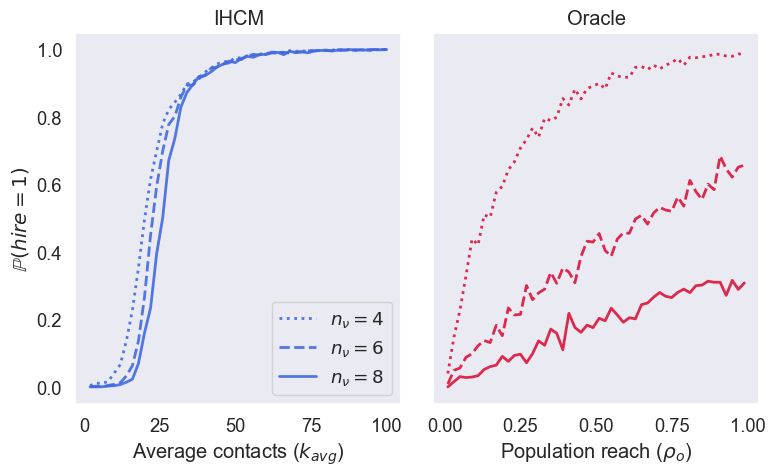

In [16]:
### HIRING PROBABILITIES ###
fig, ax = plt.subplots( figsize=(8,5), ncols=2, sharey=True )
agg_func = np.mean

ls = ['dotted', '--', '-']
ms = ['^', 's', 'o'] 
label = 'Specificity: '

for i, CI in enumerate(CIs):

    n_ν = int(max( poisson.interval(CI, λ) )) 
    label = "$n_\\nu = {}$".format(n_ν)
    pd.Series(results_social_hiring_varying_k[CI]).apply(agg_func).plot(ls=ls[i], lw=2, alpha=0.9, label=label, color=cs[0], ax=ax[0] )
    pd.Series(results_oracle_hiring_varying_rho[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.9, label=label, color=cs[1], ax=ax[1] )
    # pd.Series(results_oracle_hiring_varying_rho[CI]).apply(agg_func).plot( marker=ms[i], lw=0, ms=3, alpha=0.9, label=label, color=cs[1], ax=ax[1] )

    ax[0].set_title("IHCM")
    ax[0].set_ylabel("$\mathbb{P}(hire = 1)$")
    ax[0].set_xlabel("Average contacts ($k_{avg}$)")
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title("Oracle")
    # ax[1].set_ylabel("$\mathbb{P}(hire = 1)$")
    ax[1].set_xlabel("Population reach ($\\rho_o$)")
    # ax[1].legend()
    ax[1].grid()

# plt.suptitle("Hiring success")
plt.tight_layout();

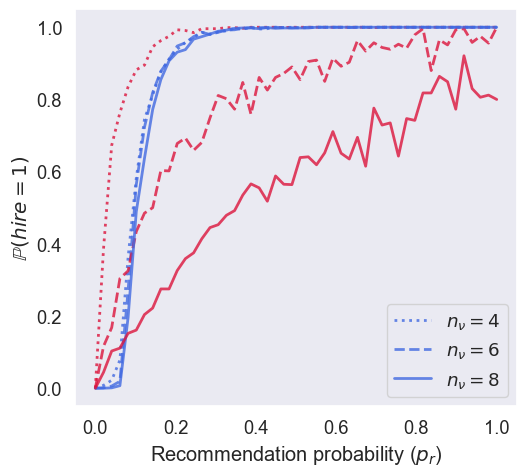

In [17]:
fig, ax = plt.subplots( figsize=(5.5, 5) )
agg_func = np.mean

ls = ['dotted', '--', '-']
ms = ['^', 's', 'o'] 
label = 'Specificity: '

for i, CI in enumerate(CIs):

    n_ν = int(max( poisson.interval(CI, λ) )) 
    label = "$n_\\nu = {}$".format(n_ν)
    pd.Series(results_social_hiring_varying_pr[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.8, marker='o', ms=0, color=cs[0], ax=ax, label=label )
    pd.Series(results_oracle_hiring_varying_pr[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.8, marker='o', ms=0, color=cs[1], ax=ax )
    # pd.Series(results_hiring_oracle[CI]).apply(agg_func).plot( marker=ms[i], lw=0, ms=3, alpha=0.9, label=label, color=cs[1], ax=ax[1] )

    # ax.set_title("X")
    ax.set_ylabel("$\mathbb{P}(hire = 1)$")
    ax.set_xlabel("Recommendation probability ($p_r$)")
    ax.legend()
    ax.grid()

# plt.suptitle("Hiring success")
plt.tight_layout();

### Chain depths

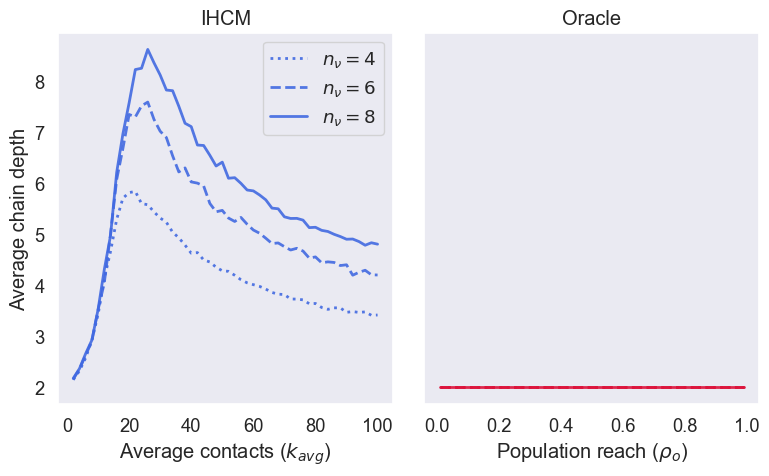

In [18]:
fig, ax = plt.subplots( figsize=(8,5), ncols=2, sharey=True )
agg_func = np.mean

ls = ['dotted', '--', '-']
ms = ['^', 's', 'o'] 
label = 'Specificity: '

for i, CI in enumerate(CIs):

    n_ν = int(max( poisson.interval(CI, λ) )) 
    label = "$n_\\nu = {}$".format(n_ν)
    pd.Series(results_social_depths_varying_k[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.9, label=label, color=cs[0], ax=ax[0] )
    pd.Series(results_oracle_depths_varying_rho[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.9, label=label, color=cs[1], ax=ax[1] )
    # pd.Series(results_oracle_depths_varying_rho[CI]).apply(agg_func).plot( marker=ms[i], lw=0, ms=3, alpha=0.9, label=label, color=cs[1], ax=ax[1] )

    ax[0].set_title("IHCM")
    ax[0].set_ylabel("Average chain depth")
    ax[0].set_xlabel("Average contacts ($k_{avg}$)")
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title("Oracle")
    # ax[1].set_ylabel("$\mathbb{P}(hire = 1)$")
    ax[1].set_xlabel("Population reach ($\\rho_o$)")
    # ax[1].legend()
    ax[1].grid()

# plt.suptitle("Hiring success")
plt.tight_layout();

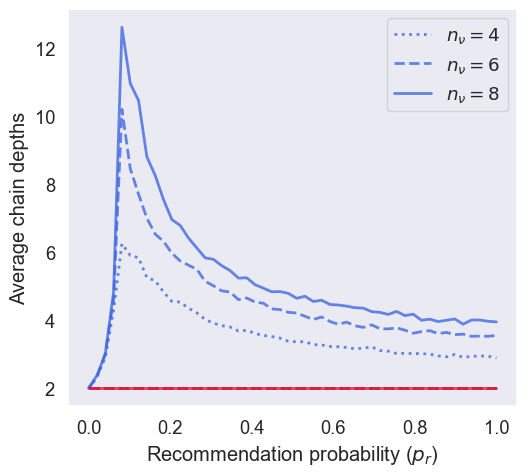

In [19]:
fig, ax = plt.subplots( figsize=(5.5, 5) )
agg_func = np.mean

ls = ['dotted', '--', '-']
ms = ['^', 's', 'o'] 
label = 'Specificity: '

for i, CI in enumerate(CIs):

    n_ν = int(max( poisson.interval(CI, λ) )) 
    label = "$n_\\nu = {}$".format(n_ν)
    pd.Series(results_social_depths_varying_pr[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.8, color=cs[0], ax=ax, label=label )
    pd.Series(results_oracle_depths_varying_pr[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.8, color=cs[1], ax=ax )
    # pd.Series(results_hiring_oracle[CI]).apply(agg_func).plot( marker=ms[i], lw=0, ms=3, alpha=0.9, label=label, color=cs[1], ax=ax[1] )

    # ax.set_title("X")
    ax.set_ylabel("Average chain depths")
    ax.set_xlabel("Recommendation probability ($p_r$)")
    ax.legend()
    ax.grid()

# plt.suptitle("Hiring success")
plt.tight_layout();

### Applicants volume

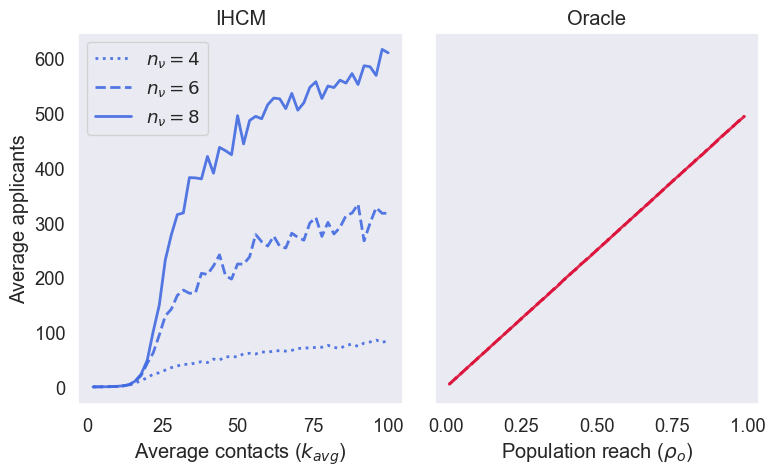

In [20]:
fig, ax = plt.subplots( figsize=(8,5), ncols=2, sharey=True )
agg_func = np.mean

ls = ['dotted', '--', '-']
ms = ['^', 's', 'o'] 
label = 'Specificity: '

for i, CI in enumerate(CIs):

    n_ν = int(max( poisson.interval(CI, λ) )) 
    label = "$n_\\nu = {}$".format(n_ν)
    pd.Series(results_social_applicants_varying_k[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.9, label=label, color=cs[0], ax=ax[0] )
    pd.Series(results_oracle_applicants_varying_rho[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.9, label=label, color=cs[1], ax=ax[1] )
    
    # pd.Series(results_social_applicants_varying_k[CI]).apply(agg_func).plot( marker=ms[i], lw=0, ms=3, alpha=0.9, label=label, color=cs[0], ax=ax[0] )
    # pd.Series(results_oracle_applicants_varying_rho[CI]).apply(agg_func).plot( marker=ms[i], lw=0, ms=3, alpha=0.9, label=label, color=cs[1], ax=ax[1] )

    ax[0].set_title("IHCM")
    ax[0].set_ylabel("Average applicants")
    ax[0].set_xlabel("Average contacts ($k_{avg}$)")
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title("Oracle")
    # ax[1].set_ylabel("$\mathbb{P}(hire = 1)$")
    ax[1].set_xlabel("Population reach ($\\rho_o$)")
    # ax[1].legend()
    ax[1].grid()

# plt.suptitle("Hiring success")
plt.tight_layout();

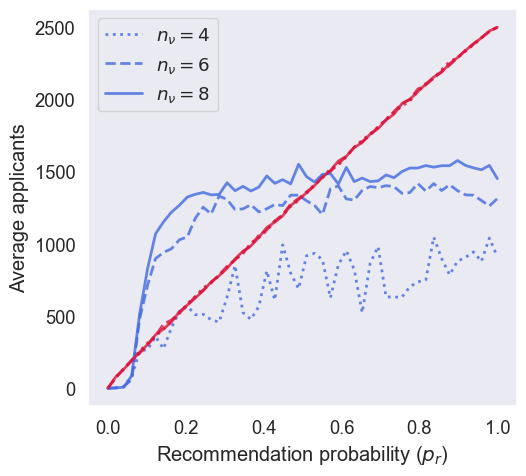

In [21]:
fig, ax = plt.subplots( figsize=(5.5, 5) )
agg_func = np.max

ls = ['dotted', '--', '-']
ms = ['^', 's', 'o'] 
label = 'Specificity: '

for i, CI in enumerate(CIs):

    n_ν = int(max( poisson.interval(CI, λ) )) 
    label = "$n_\\nu = {}$".format(n_ν)
    pd.Series(results_social_applicants_varying_pr[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.8, marker='o', ms=0, color=cs[0], ax=ax, label=label )
    pd.Series(results_oracle_applicants_varying_pr[CI]).apply(agg_func).plot( ls=ls[i], lw=2, alpha=0.8, marker='o', ms=0, color=cs[1], ax=ax )
    # pd.Series(results_hiring_oracle[CI]).apply(agg_func).plot( marker=ms[i], lw=0, ms=3, alpha=0.9, label=label, color=cs[1], ax=ax[1] )

    # ax.set_title("X")
    ax.set_ylabel("Average applicants")
    ax.set_xlabel("Recommendation probability ($p_r$)")
    ax.legend()
    ax.grid()

# plt.suptitle("Hiring success")
plt.tight_layout();

### Distribution evolution

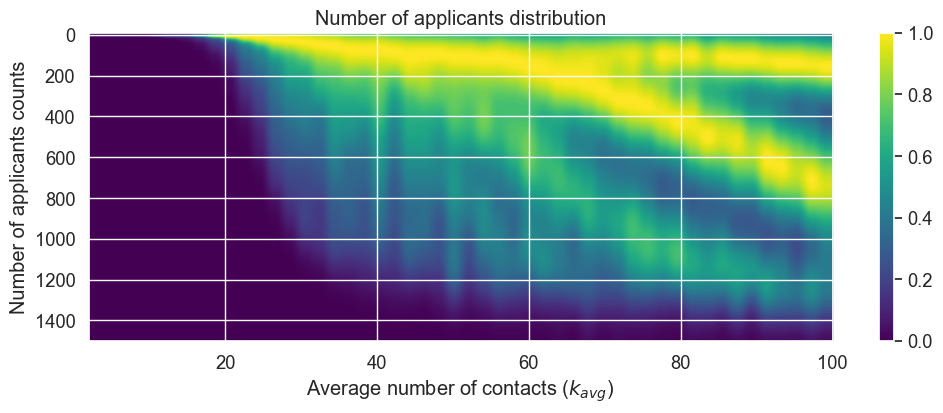

In [22]:
CI = 0.99
xmin, xmax = -10, 1500 # number of applicants
n_vals = 500 # for the KDE distribution fit
kde_input_vec = np.linspace(xmin, xmax, n_vals)

n_params = len( results_social_applicants_varying_k[CI] )
distribution_matrix = np.zeros((n_vals, n_params))

for col, (kavg, applicants_results) in enumerate( results_social_applicants_varying_k[CI].items() ):
    
    # initialize and fit kde object
    kde = gaussian_kde( applicants_results )

    # compute the KDE histogram values
    kde_vals = kde( kde_input_vec )
    # normalize
    kde_vals /= max(kde_vals)

    distribution_matrix[:, col] = kde_vals

# Plot the heatmap
plt.figure( figsize=(12,4) )
plt.imshow(distribution_matrix, extent=[k_avgs[0], k_avgs[-1], xmax, xmin], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Number of applicants distribution')
plt.xlabel('Average number of contacts ($k_{avg}$)')
plt.ylabel('Number of applicants counts')
plt.show()

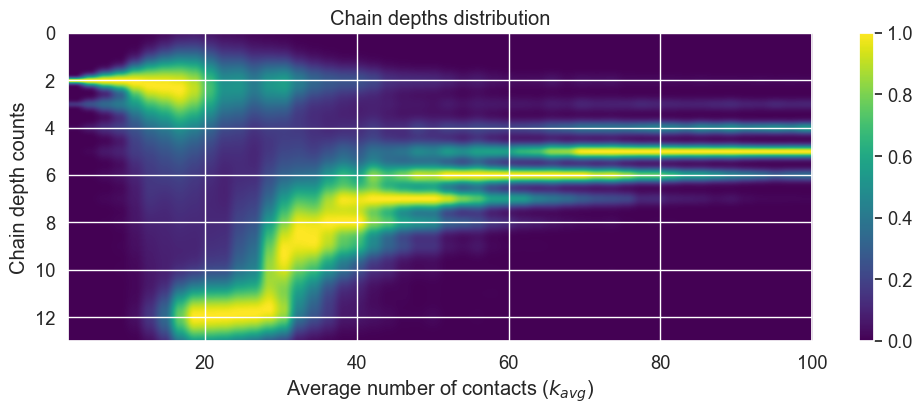

In [23]:
CI = 0.99
xmin, xmax = 0, 13 # number of applicants
n_vals = 500 # for the KDE distribution fit
kde_input_vec = np.linspace(xmin, xmax, n_vals)

n_params = len( results_social_depths_varying_k[CI] )
distribution_matrix = np.zeros((n_vals, n_params))

for col, (kavg, applicants_results) in enumerate( results_social_depths_varying_k[CI].items() ):
    
    # initialize and fit kde object
    kde = gaussian_kde( applicants_results )

    # compute the KDE histogram values
    kde_vals = kde( kde_input_vec )
    # normalize
    kde_vals /= max(kde_vals)

    distribution_matrix[:, col] = kde_vals

# Plot the heatmap
plt.figure( figsize=(12,4) )
plt.imshow(distribution_matrix, extent=[k_avgs[0], k_avgs[-1], xmax, xmin], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Chain depths distribution')
plt.xlabel('Average number of contacts ($k_{avg}$)')
plt.ylabel('Chain depth counts')
plt.show()

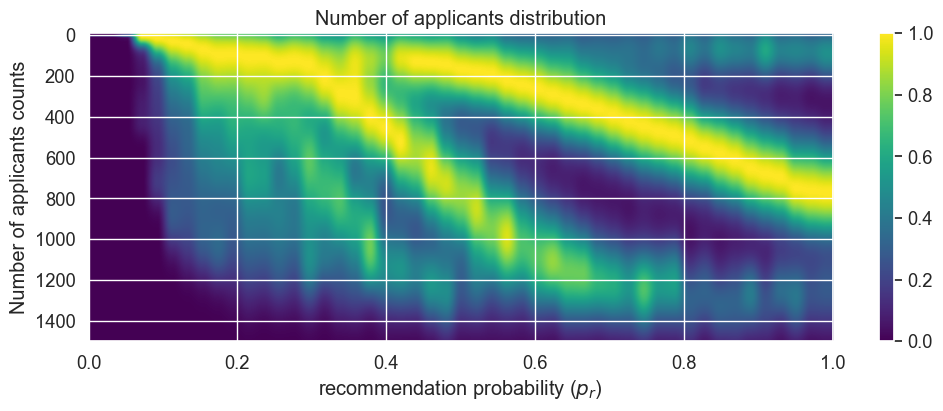

In [24]:
CI = 0.99
xmin, xmax = -10, 1500 # number of applicants
n_vals = 500 # for the KDE distribution fit
kde_input_vec = np.linspace(xmin, xmax, n_vals)

n_params = len( results_social_applicants_varying_pr[CI] )
distribution_matrix = np.zeros((n_vals, n_params-1))

for col, (kavg, applicants_results) in enumerate( results_social_applicants_varying_pr[CI].items() ):

    if col == 0:
        continue
        
    # initialize and fit kde object
    kde = gaussian_kde( applicants_results )

    # compute the KDE histogram values
    kde_vals = kde( kde_input_vec )
    # normalize
    kde_vals /= max(kde_vals)

    distribution_matrix[:, col-1] = kde_vals

# Plot the heatmap
plt.figure( figsize=(12,4) )
plt.imshow(distribution_matrix, extent=[p_rs[0], p_rs[-1], xmax, xmin], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Number of applicants distribution')
plt.xlabel('recommendation probability ($p_{r}$)')
plt.ylabel('Number of applicants counts')
plt.show()

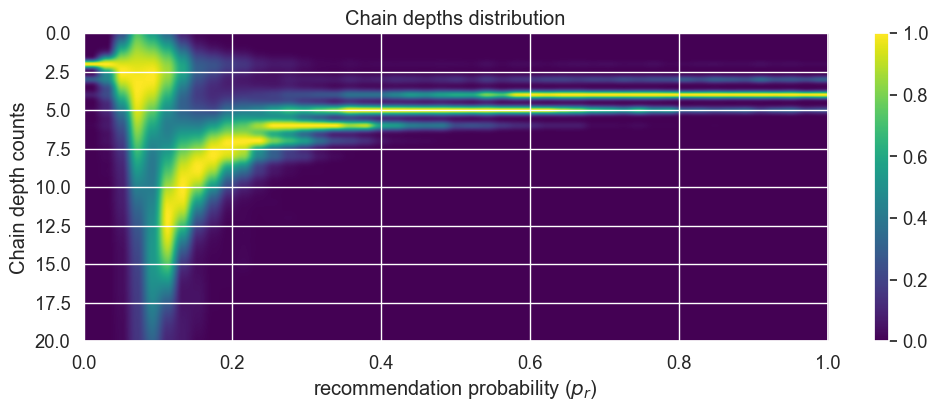

In [25]:
CI = 0.99
xmin, xmax = 0, 20 # number of applicants
n_vals = 500 # for the KDE distribution fit
kde_input_vec = np.linspace(xmin, xmax, n_vals)

n_params = len( results_social_depths_varying_pr[CI] )
distribution_matrix = np.zeros((n_vals, n_params-1))

for col, (kavg, applicants_results) in enumerate( results_social_depths_varying_pr[CI].items() ):

    if col == 0:
        continue
        
    # initialize and fit kde object
    kde = gaussian_kde( applicants_results )

    # compute the KDE histogram values
    kde_vals = kde( kde_input_vec )
    # normalize
    kde_vals /= max(kde_vals)

    distribution_matrix[:, col-1] = kde_vals

# Plot the heatmap
plt.figure( figsize=(12,4) )
plt.imshow(distribution_matrix, extent=[p_rs[0], p_rs[-1], xmax, xmin], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Chain depths distribution')
plt.xlabel('recommendation probability ($p_{r}$)')
plt.ylabel('Chain depth counts')
plt.show()